# Chunking Fiqa Dataset
In this Notebook I will analyse the Fiqa Dataset and transform it to apply some chunking strategies

## Chunking Considerations
- **What kind of Data are we working with?**
    - size of content (long document like articles or book, or shorter content like tweets or messages)
    - structure of content (plain text, code, tables,...)
- **Which embedding model are we using and what chunk size does it perform optimally on?**
- **How will the user queries look like?**
    - Short and specific or long and complex
- **How will the retrieved results be use?**
    - e.g. sematic search, question answering, summarization

### Papers
- [Pinecone: Chunking Strategies](https://www.pinecone.io/learn/chunking-strategies/)
- [Paper about Financial Report Chunking for RAG](https://arxiv.org/html/2402.05131v2)


In [ ]:
# Load enviroment variables
# import os
# from dotenv import load_dotenv

# os.environ.get('OPENAI_API_KEY') d


## Analysis
The Fiqa Dataset is a long text dataset. It is already divided into rows.

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
fiqa_corpus = load_dataset("explodinggradients/fiqa", "corpus")

print('Number of Rows (Chunks):' , len(fiqa_corpus['corpus']['doc']))

length_of_rows = []
for doc in fiqa_corpus['corpus']['doc']:
    length_of_rows.append(len(doc))

length_of_rows.sort(reverse=True)
# len function counts number of characters
print('Length of Rows: ', length_of_rows)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_rows, bins=50, color='blue', edgecolor='black')  

plt.title('Distributions of Row Length FIQA Corpus')
plt.xlabel('Length of Row')
plt.ylabel('Number of Rows')

plt.show()



NameError: name 'load_dataset' is not defined

We can see that the size of the rows vary a lot and some are very long. So we need to get the full text and rechunk the data so we have a clean chunking strategy.

*Maybe analyze also the content of some chunks or just view the [dataset](https://huggingface.co/datasets/explodinggradients/fiqa).*

**Embed chunks and store into ChromaDB Vectorstore**

In [13]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.docstore.document import Document

vectorstore = Chroma(persist_directory='../vectorstores/original_chunks', embedding_function=OpenAIEmbeddings(model='text-embedding-3-small'))
corpus_len = len(fiqa_corpus['corpus'])

for index, doc in enumerate(fiqa_corpus["corpus"]):
    # log.info(f"Processing document {index + 1} of {corpus_len}")
    doc = Document(page_content=doc["doc"], metadata={"source": "local", "id": index})
    vectorstore.add_documents([doc])


- Duration for embeddings: 282 min
- Costs for embeddings: 0,20 $

## Chunking

First, I will convert the Fiqa Dataset I downloaded as csv to a text file, because for me it is easier to handle with text files.
In the text file each row will be in an new line.

In [ ]:
import csv
with open("../fiqa_dataset/corpus.txt", "w") as my_output_file:
    with open("../fiqa_dataset/corpus.csv", "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [1]:
with open("../fiqa_dataset/corpus.txt") as f:
    fiqa_corpus = f.read()

### Fixed-size chunking
- we decide how big each chunk should be and whether there should be an overlap between them to keep a little semantic context
- computatially cheap and simple

#### Chunksize 1000 and overlap 200

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])


In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()


In [4]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore_1000 = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_1000'
)

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


- took only 11 min

#### Chunksize 1500 and overlap 300

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=1500,
    chunk_overlap=300,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])

In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()

In [13]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_1500'
)

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


#### Chunksize 2000 and overlap 400

In [20]:
text_splitter = RecursiveCharacterTextSplitter(
    separators = [".", "\n", "\n\n"],
    chunk_size=2000,
    chunk_overlap=400,
    length_function=len,
    is_separator_regex=False
)

texts = text_splitter.create_documents([fiqa_corpus])

In [ ]:
print('Number of Chunks: ', len(texts))

length_of_chunks = []
for doc in texts:
    length_of_chunks.append(len(doc.page_content))

length_of_chunks.sort(reverse=True)

print('Length of Chunks: ', length_of_chunks)

plt.figure(figsize=(10, 6))  
plt.hist(length_of_chunks, bins=50, color='blue', edgecolor='black')  

plt.title('Fixed Size Chunking (1000)')
plt.xlabel('Length of Chunks')
plt.ylabel('Number of Chunks')

plt.show()

In [22]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

# Create an instance of OpenAIEmbeddings
embedding_function = OpenAIEmbeddings(model='text-embedding-3-small')

# Use the Chroma.from_documents class method with keyword arguments
vectorstore_2000 = Chroma.from_documents(
    texts, 
    embedding_function,
    persist_directory='../vectorstores/fixed_size_2000'
)

**First evaluation**
- {'answer_relevancy': 0.3993, 'answer_correctness': 0.2876, 'context_recall': 0.4284, 'context_relevancy': 0.0443}

### Semantic Chunking

In [4]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
import re

text_splitter = SemanticChunker(OpenAIEmbeddings(model='text-embedding-3-small'))

In [5]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import logger

load_dotenv()

oaiembeds = OpenAIEmbeddings(model='text-embedding-3-small', api_key=os.environ.get('OPENAI_API_KEY'))

First I want to check how semantic similiar the provided chunks are.

In [7]:
with open('../fiqa_dataset/corpus.txt') as file:
    corpus = file.read()

sen_list = re.split(r'(?<=[.?!])\s+', corpus)

print("Number of sentences", len(sen_list))

Number of sentences 399187


In [9]:
docs = text_splitter.split_text(corpus)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa8c10083a0>>
Traceback (most recent call last):
  File "/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [36]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sen_list)]
sentences[:4]

[{'sentence': 'So nothing preventing false ratings besides additional scrutiny from the market/investors, but there are some newer controls in place to prevent institutions from using them.',
  'index': 0},
 {'sentence': "Under the DFA banks can no longer solely rely on credit ratings as due diligence to buy a financial instrument, so that's a plus.",
  'index': 1},
 {'sentence': "The intent being that if financial institutions do their own leg work then *maybe* they'll figure out that a certain CDO is garbage or not.",
  'index': 2},
 {'sentence': 'Edit: lead in', 'index': 3}]

In [47]:
embeddings = oaiembeds.embed_documents([x['sentence'] for x in sentences])

for i, sentence in enumerate(sentences):
    sentence['sentence_embedding'] = embeddings[i]

sentences[0]


{'sentence': 'So nothing preventing false ratings besides additional scrutiny from the market/investors, but there are some newer controls in place to prevent institutions from using them.',
 'index': 0,
 'sentence_embedding': [-0.010783213060235565,
  0.014183262191429876,
  0.029926050092212025,
  0.07097953472068459,
  0.034506283282869914,
  0.028029329735575214,
  -0.009891051679357062,
  -0.024039188108987832,
  0.031162431086470377,
  -0.015904361189651675,
  0.00942038360758423,
  -0.06547201345602653,
  -0.01860192023057311,
  0.020765587436186506,
  -0.009062114062013767,
  -0.02354744607025164,
  0.02493837631860677,
  -0.0019687267247750027,
  -0.057210739009619954,
  0.05251811008672739,
  0.002681753565698916,
  0.019964750614547007,
  -0.020175497734761128,
  -0.02964505517368995,
  0.01768868395140868,
  -0.04953955426463875,
  -0.014274585819346318,
  -0.022100317955779172,
  -0.004467832801810392,
  0.012651835415136271,
  0.0537825928080121,
  -0.039564206717428246,


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['sentence_embedding']
        embedding_next = sentences[i + 1]['sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [40]:
distances, sentences = calculate_cosine_distances(sentences)

distances[2]

0.7953087686371845

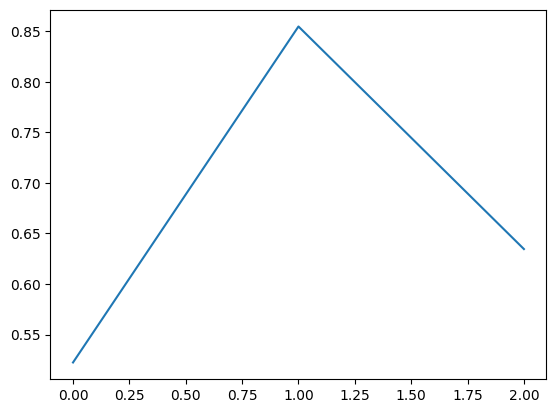

In [24]:
import matplotlib.pyplot as plt

plt.plot(distances)

In [ ]:
docs = text_splitter.create_documents([fiqa_corpus])

In [ ]:
vectorstore_semantic = Chroma.from_documents(
    docs, 
    embedding_function,
    persist_directory='../vectorstores/semantic_chunks'
)